In [194]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import networkx as nx
import spacy
%pylab inline

tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@Noelia_Carrion9_tweets.csv')

tweets_user.head()

def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

tweets_user['RT'] = tweets_user.text.apply(retweet)

tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

tweets_user['date'] = tweets_user['created_at']

tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

nlp = es_core_news_sm.load()

nlp = spacy.load('es', parser=True)

nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt"}

def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

array_matrix = tfidf_matrix.toarray()

first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

vocab = tfidf_vectorizer.vocabulary_

dist = 1 - cosine_similarity(tfidf_matrix)
dist

umap = UMAP(n_components=2, n_neighbors=5)
embedding = umap.fit_transform(dist)

umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

umap_df.head()

plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

hdbscan = HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

hdbscan.labels_.max()

labels = hdbscan.labels_

fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))

num_clusters = 8

km = KMeans(n_clusters=num_clusters, init = 'k-means++',max_iter=300,n_init=10)

%time clustering = km.fit_predict(embedding)

clusters = km.labels_.tolist()

fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
centers = np.array(km.cluster_centers_)

plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet', 'words', "cluster"])

frame[frame['cluster']==4].head()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(20)



Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'time', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [165]:
tweets_user.mention.value_counts()

1.419712e+17    1
7.583049e+17    1
7.814585e+17    1
8.018444e+17    1
7.808245e+17    1
               ..
8.465564e+14    1
1.156509e+18    1
1.156508e+18    1
1.156245e+18    1
1.156509e+18    1
Name: mention, Length: 441, dtype: int64

In [190]:
tweets_user = tweets_user[tweets_user['mention']!=""]

tweets_user['mention'].value_counts()

el_pais                                    10
NCINoticias                                 9
elmundoes                                   9
ramonlobo                                   7
CursosVeranoUCM                             7
                                           ..
ManuelaCarmena                              1
MadridDestino, fernangomezCCV               1
NCINoticias, uni                            1
plenaiandalucia                             1
NCINoticias, A_Valenzuela, YaVeremosM80     1
Name: mention, Length: 329, dtype: int64

In [191]:
df = pd.DataFrame({
    'user':['user1','user2','user2'],
    'mentioned_user':['jack,peter,anne','sophie','anne,user1']
})

In [192]:
df

,user,mentioned_user
0,user1,"jack,peter,anne"
1,user2,sophie
2,user2,"anne,user1"


/miniconda3/envs/py366/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/miniconda3/envs/py366/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


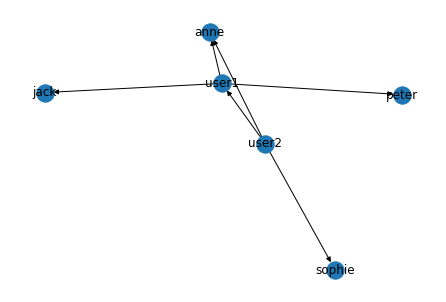

In [195]:
df['splitted_users'] = df['mentioned_user'].apply(lambda x: x.split(','))

G = nx.DiGraph()
for r in df.iterrows():
    for user in r[1]['splitted_users']:
        G.add_edge(r[1]['user'], user)
nx.draw(G, with_labels=True)

In [196]:
df['splitted_users'] 

0    [jack, peter, anne]
1               [sophie]
2          [anne, user1]
Name: splitted_users, dtype: object